In [18]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import joblib
import pickle
import torch
from xgboost import XGBRegressor
from darts import TimeSeries
from darts.models import  RandomForest, LinearRegressionModel,  \
                        LightGBMModel, CatBoostModel, XGBModel,  \
                        BlockRNNModel, NBEATSModel, NHiTSModel, \
                        TCNModel, TFTModel


from sklearn.svm import SVR
from sklearn.linear_model import PoissonRegressor

from statsmodels.tsa.statespace.sarimax import SARIMAX

from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood

import warnings
warnings.filterwarnings('ignore')

# Configuration

In [19]:
prj_path = '../'
data_path = prj_path + "data/new_data/DH/squeezed/"
prj_path_opt= prj_path + "optimize_hyperparam/opt_results/"
output_process = prj_path + "data/new_data/DH/processed_data/"
output_featureselection = prj_path + "data/new_data/DH/feature_selection/"

In [20]:
all_cities = [
        'An Giang', 'BR Vũng Tàu', 'Bình Phước', 'Bình Thuận', 'Bình Định',
        'Bạc Liêu', 'Bắc Kạn', 'Bắc Giang', 'Cao Bằng', 'Cà Mau',
        'Cần Thơ', 'Gia Lai', 'Hà Giang', 'Hà Nội', 'Hà Tĩnh',
        'Hòa Bình','Hưng Yên', 'Hải Dương', 'Hải Phòng', 'Khánh Hòa', 'Kiên Giang',
        'Kon Tum', 'Lai Châu', 'Long An', 'Lào Cai', 'Lâm Đồng',
        'Lạng Sơn','Nam Định', 'Nghệ An', 'Ninh Bình', 'Ninh Thuận',
        'Phú Thọ', 'Phú Yên', 'Quảng Bình', 'Quảng Nam', 'Quảng Ngãi',
        'Quảng Ninh', 'Quảng Trị', 'Sóc Trăng', 'Sơn La', 'TT Huế',
        'Thanh Hóa', 'Thái Bình', 'Thái Nguyên', 'Tiền Giang', 'Trà Vinh',
        'Tuyên Quang', 'Tây Ninh', 'Vĩnh Phúc', 'Yên Bái', 'Điện Biên',
        'Đà Nẵng', 'Đắk Nông', 'Đắk Lắk', 'Đồng Tháp'
]
# cities = ['Hà Nội','Hải Phòng','Quảng Ninh','Nam Định','Thái Bình','Quảng Nam','Quảng Ngãi', 'Phú Yên',
#           'Ninh Thuận', 'Bình Thuận', 'Tây Ninh', 'Bình Phước', 'An Giang', 'Tiền Giang','Cần Thơ', 'Trà Vinh']

cities = ['An Giang','Quảng Ninh']

In [21]:
# Set hyperparameters as args using the Configuration class
class Configuration():
    def __init__(self):
        # lấy bộ test dài 36 tháng = 3 năm
        self.test_size = 36
        # là nhìn vào dữ liệu trước 3 tháng và dự phóng        
        self.look_back = 3
        # dự phóng n-step trong 6 tháng
        self.n_predicted_period_months = 6
        self.n_features = 3
        self.seed = 42
        # mỗi phần tử x trong tập suppervise có độ lớn là 16 = 16 tháng
        self.batch_size = 16
        self.device = torch.device("cuda")
        self.epochs = 300
        #others
        self.labels = "Dengue_fever_rates"
        # Input param for Optimize Run
        self.ntry = 1
        self.njob = 1

args = Configuration()

# Seeding

In [22]:
def seed_everything(seed: int):
    import random
    import numpy as np
    import torch
    
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everything(args.seed)

# Supporting functions

In [23]:
import requests

def send_to_telegram(message):

    apiToken = '5908735099:AAGVSLrW62aXPBP-GrMvxoVgMsuJxXJpP1Q'
    chatID = '@ptn_announcement'
    apiURL = f'https://api.telegram.org/bot{apiToken}/sendMessage'

    try:
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message})
        print(response.text)
    except Exception as e:
        message_error = "Bị lỗi rùi: "+str(e)
        response = requests.post(apiURL, json={'chat_id': chatID, 'text': message_error})
        print(e)

In [24]:
def get_dict_all_city_data():
  cities_data = {}  
  for city in cities:
    city_result = pd.read_excel(prj_path+'data/new_data/DH/squeezed/squeezed_'+city+'.xlsx')  
    """Get all data from all city in 1997 - 2016""" 
    city_result = city_result.loc[city_result['year_month'] < '2017-1-1'] 
    cities_data[city] = city_result
  return cities_data

In [25]:
# Define data (pre-)processing functions
# modification
def get_city_data(city_name, dict_full_data):
    """Returns Diarrhoea rate and climate data""" 
    city_data = dict_full_data[city_name].drop(columns=['Diarrhoea_cases','Diarrhoea_rates', 'province',
                                                        'Influenza_rates','Influenza_cases',
                                                        'Dengue_fever_cases', 'year', 'month'], 
                                                                  axis=1, 
                                                                  inplace=False)    
    return city_data

def convert_to_stationary(city_data):
    """Subtracts previous value for all cols except disease rates"""
    for col_name in city_data.columns:
        if col_name != 'Diarrhoea_rates':
            try:
                city_data[col_name] = city_data[col_name] - city_data[col_name].shift()
            except:
                print(col_name)
    return city_data

def impute_missing_value(city_data):
    """
    Imputes 0 for first 12 months, 
    last year's value for months 12-24, 
    and minimum value of last two years for months 25+
    """
    for col in city_data.columns:
        for index in range(len(city_data[col])):
            if np.isnan(city_data[col].iloc[index]):
                if index < 12:
                    city_data[col].iloc[index] = 0
                elif index >= 12 and index <= 24:
                    city_data[col].iloc[index] = city_data[col].iloc[index - 12]
                else:
                    city_data[col].iloc[index] = min(city_data[col].iloc[index - 12], city_data[col].iloc[index - 24])
    return city_data

In [26]:
def clean_full_data(dict_full_data):
    climate_and_disease_feats = ['Total_Evaporation',
       'Total_Rainfall', 'Max_Daily_Rainfall', 'n_raining_days',
       'Average_temperature', 'Max_Average_Temperature',
       'Min_Average_Temperature', 'Max_Absolute_Temperature',
       'Min_Absolute_Temperature', 'Average_Humidity', 'Min_Humidity',
       'n_hours_sunshine', 'Dengue_fever_rates']
    for city in cities:
        city_data = get_city_data(city_name=city,dict_full_data = dict_full_data)
        city_data_features = city_data[climate_and_disease_feats]
        city_data_features = impute_missing_value(city_data_features)
        city_data_features = convert_to_stationary(city_data_features)
        city_data_features.dropna(inplace=True)
        city_data_features.loc[:, "year_month"] = city_data["year_month"]
        dict_full_data[city] = city_data_features
    return dict_full_data


In [27]:
def split_data(data, look_back, n_nextstep = args.n_predicted_period_months):
    """Splits data into train and test sets based on args (Configuration class)"""
    train = data[: -args.test_size]    
    test = data[-args.test_size - look_back-(n_nextstep - 1): ]
    return train, test

In [28]:
def to_supervised(data,  d_out, d_in, features_list=[]):
    """
    Frames time-series as supervised learning dataset.
    
    Args:
      d_in: lookback window
      d_out: number of predicted months
      features_list: list of all features **where last col is the disease incidence**

    Returns:
      Numpy arrays of disease incidence (y) and other predictors (X)
    """
    X, y = list(), list()
    for index, _ in enumerate(data):
        in_end = index + d_in
        out_end = in_end + d_out
        if out_end <= len(data):
            if len(features_list) == 0 :
                X.append(data[index: in_end, :-1])
            else:
                X.append(data[index: in_end, features_list])
            y.append(data[out_end-1: out_end, -1])
    return np.array(X), np.array(y).reshape(len(y))

In [29]:
def getDataWithSelectedFeature(city, next_predicted_month):
  selected_feature = []
  df = pd.read_csv(output_featureselection+str(next_predicted_month)+"step_feature_selection_3_most.csv")
  for row in range(len(df)):
    if (df["City"][row] == city):
      selected_feature.append(df["1st_Feature"][row])
      selected_feature.append(df["2nd_Feature"][row])
      selected_feature.append(df["3rd_Feature"][row])
  return selected_feature

In [30]:
def train_and_evaluate(df_train, df_eval, model, location, feature_list, labels, scaler):
    """
    $df: pandas.DataFrame object containing data for training and testing model:
    $model: darts model object
    $feature_list: Names of the features used as model input
    $label: the value the model will be trained to predict
    $scaler: scaler object. Note: the scaler will be fitted on training data and applied to test data
    $lags: how much to look back into the past to output prediction
    $split_index: the point at which to divide train and test_data

    """    
    print("🍋🍋🍋🍋🍋Check var feature selection: ",feature_list)
    x_train = TimeSeries.from_dataframe(df_train, "year_month", feature_list)
    y_train = TimeSeries.from_dataframe(df_train, "year_month", labels)
    x_test = TimeSeries.from_dataframe(df_eval, "year_month", feature_list)
    y_test = TimeSeries.from_dataframe(df_eval, "year_month", labels)

    #Cách một khoảng phần này cho x_train thì mới đưa đc chuỗi x_test vừa đủ để dự đoán 36 lần 6step
        # ValueError: For the given forecasting horizon `n=xxx`, the provided 
        # past covariates at dataset index `0` do not extend far enough into 
        # the future. As `n > output_chunk_length` the past covariates must 
        # start at time step `xxxxxx`, whereas now they start at 
        # time step `xxxxx`.

    x_train_back = x_train[:-(args.n_predicted_period_months-1)]
    y_train_back = y_train[:-(args.n_predicted_period_months-1)]

    predict_list = []
    for i in range (args.test_size+(args.n_predicted_period_months-1)):
        print("🍭🍭🍭🍭🍭🍭🍭🍭🍭")
        print("y_train_back: ",len(y_train_back))
        print("x_train_back: ",len(x_train_back))
        model.fit(y_train_back, past_covariates = x_train_back)
        prediction = model.predict(6)
        x_train_back = x_train_back.append(x_test[i+3])
        predict_list.append(np.array(prediction._xa).squeeze())
    y_pred_list = []
    for step in range(args.n_predicted_period_months):
        moving = args.n_predicted_period_months-1-step
        y_pred_list.append([x[step] for x in predict_list][moving:args.test_size+moving])

    y_true = df_eval[labels][-args.test_size:].values

    y_pred_inverse_list = []
    for step in range(args.n_predicted_period_months):
        df_eval_pred_inverse = df_eval[-args.test_size:]
        df_eval_pred_inverse[args.labels]= y_pred_list[step] #step 1
        y_pred_inverse = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)
        y_pred_inverse_list.append(y_pred_inverse)

    y_pred_inverse_list
    df_compare_test_predict = pd.DataFrame({
        'y_true':y_true,
        'y_pred_1step':y_pred_inverse_list[0],
        'y_pred_2step':y_pred_inverse_list[1],
        'y_pred_3step':y_pred_inverse_list[2],
        'y_pred_4step':y_pred_inverse_list[3],
        'y_pred_5step':y_pred_inverse_list[4],
        'y_pred_6step':y_pred_inverse_list[5],
        })
    df_compare_test_predict.plot()
    plt.legend()
    plt.show()
    mse_nstep = []
    mae_nstep = []
    rmse_nstep = []
    mape_nstep = []
    for step in range(args.n_predicted_period_months):
        mse_nstep.append(mean_squared_error(y_true, y_pred_inverse_list[step]))
        mae_nstep.append(mean_absolute_error(y_true, y_pred_inverse_list[step]))
        rmse_nstep.append(mse_nstep[step]**0.5)
        mape_nstep.append(mean_absolute_percentage_error(y_true, y_pred_inverse_list[step]))
    return model, y_true, y_pred_inverse_list, mse_nstep, mae_nstep, rmse_nstep, mape_nstep


In [31]:
def output_prediction_for_location(df_train, df_eval, model, location, feature_list, 
                                                labels, scaler):
    """train and generate prediction for a province
    df: DataFrame object containing features and label(s) for training model
    localtion: location_name
    feature_list: list of features used as model input,  must be among the column names of df
    labels: the values model will be trained to predict
    scaler: sklearn scaler object
    lags: how long into the past to look back when making prediction
    split_index: the point at which to divide data into the train and test subsets.
    """
    model, y_true, y_pred_inverse_list, mse_nstep, mae_nstep, rmse_nstep, mape_nstep = train_and_evaluate(df_train, df_eval, model, location, feature_list, labels, scaler)
    
    df_prediction = pd.DataFrame({"Date": df_eval["year_month"][-args.test_size:],
                                  "Observed": y_true[-args.test_size:],
                                  f"{1}-month": y_pred_inverse_list[0],
                                  f"{2}-month": y_pred_inverse_list[1],
                                  f"{3}-month": y_pred_inverse_list[2],
                                  f"{4}-month": y_pred_inverse_list[3],
                                  f"{5}-month": y_pred_inverse_list[4],
                                  f"{6}-month": y_pred_inverse_list[5]})    

    df_prediction["City"] = location
    for step in range(args.n_predicted_period_months):
        df_prediction[f"RMSE_{step+1}-month"] = rmse_nstep[step]
        df_prediction[f"MAE_{step+1}-month"] = mae_nstep[step]
        df_prediction[f"MAPE_{step+1}-month"] = mape_nstep[step]
        df_prediction[f"MSE_{step+1}-month"] = mse_nstep[step]
    print("⭐️⭐️⭐️⭐️⭐️⭐️⭐️")

    return df_prediction, model

In [32]:
def getHyperParams(model_name, city):
  folder_path = f'../optimize_hyperparam/opt_results/opt_res_ml_26102023/{model_name}/'
  file_path = folder_path+ f'261023_DF_opt_hyperparam_{model_name}_multi-nstep.xlsx'
  df_optimized = pd.read_excel(file_path)
  df_optimized_params = df_optimized.loc[(df_optimized['City'] == city)]
  return df_optimized_params

# Training

## SARIMA

In [33]:
# model_name_list = [
#    "SARIMA",
# ]

# for model_name in model_name_list:   
#     print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
#     for city in cities:
#         print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
#         df_results = pd.DataFrame()
#         df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
#         df_eval = pd.read_csv(output_process+city+'_test_preprocessed_normed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
#         df_full = pd.concat([df_train, df_eval[args.n_predicted_period_months + args.look_back -1 :]], ignore_index=True, sort=False)

#         scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
#         nstep = args.n_predicted_period_months
#         selected_features = getDataWithSelectedFeature(city, nstep)
        
#         df_hyper_params = getHyperParams(model_name, city)

#         if model_name == "SARIMA":
#             p = df_hyper_params['p'].values[0]
#             d = df_hyper_params['d'].values[0]
#             q = df_hyper_params['q'].values[0]
#             t = df_hyper_params['t'].values[0]
#             P = df_hyper_params['P'].values[0]
#             D = df_hyper_params['D'].values[0]
#             Q = df_hyper_params['Q'].values[0]
#             m = df_hyper_params['m'].values[0]
#             cfg = [(p, d, q), (P, D, Q, m), t]
#             order, sorder, trend = cfg
        
#         trainlist = [x for x in df_full.Dengue_fever_rates]
#         nstep = args.n_predicted_period_months

#         predict_list = []
#         for i in range (args.test_size+(nstep-1)):
#             print("🍒",i)
#             history = trainlist[:-args.test_size-(nstep-1-i)]
#             model = SARIMAX(history, 
#                             order=order, 
#                             seasonal_order=sorder, 
#                             trend = trend,
#                             enforce_stationarity=False,
#                             enforce_invertibility=False)
#             model_fit = model.fit(disp=False)
#             yhat = model_fit.predict(len(history), len(history) + nstep - 1)
#             predict_list.append(yhat)

#         y_pred_list = []
#         for step in range(nstep):
#             moving = nstep-1-step
#             y_pred_list.append([x[step] for x in predict_list][moving:args.test_size+moving])

#         df_eval_true_inverse = df_full[-args.test_size:]
#         y_true = scaler.inverse_transform(df_eval_true_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)

#         y_pred_inverse_list = []
#         for step in range(nstep):
#             df_eval_pred_inverse = df_full[-args.test_size:]
#             df_eval_pred_inverse[args.labels]= y_pred_list[step] #step 1
#             y_pred_inverse = scaler.inverse_transform(df_eval_pred_inverse.iloc[:,:-1])[:,[-1]].reshape(args.test_size)
#             y_pred_inverse_list.append(y_pred_inverse)

#             df_compare_test_predict = pd.DataFrame({'y_true':y_true, 'y_pred':y_pred_inverse})
#             df_compare_test_predict.plot()
#             plt.legend()
#             plt.show()

#         df_results["Date"] = df_eval["year_month"][- args.test_size:]
#         df_results["City"] = city
#         df_results["Observed"] = y_true

#         for step in range(args.n_predicted_period_months):
#             df_results[f"MSE_{step+1}-month"] = mean_squared_error(y_true, y_pred_inverse_list[step])
#             df_results[f"MAE_{step+1}-month"] = mean_absolute_error(y_true, y_pred_inverse_list[step])
#             df_results[f"RMSE_{step+1}-month"] = mean_squared_error(y_true, y_pred_inverse_list[step])**0.5
#             df_results[f"MAPE_{step+1}-month"] = mean_absolute_percentage_error(y_true, y_pred_inverse_list[step])
#             df_results[f"{step+1}-month"] = y_pred_inverse_list[step]

#         result_columns = ['Date', 'City', 'Observed',
#                             'MSE_1-month', 'MAE_1-month', 'RMSE_1-month', 'MAPE_1-month',  
#                             'MSE_2-month', 'MAE_2-month', 'RMSE_2-month', 'MAPE_2-month',  
#                             'MSE_3-month', 'MAE_3-month', 'RMSE_3-month', 'MAPE_3-month',
#                             'MSE_4-month', 'MAE_4-month', 'RMSE_4-month', 'MAPE_4-month', 
#                             'MSE_5-month', 'MAE_5-month', 'RMSE_5-month', 'MAPE_5-month',  
#                             'MSE_6-month', 'MAE_6-month', 'RMSE_6-month', 'MAPE_6-month',
#                             '1-month', '2-month', '3-month', '4-month', '5-month', '6-month', 
#                             ]
#         df_results = df_results.reset_index()[result_columns]
#         folder_save_path = f"./metric_results/{model_name}/"
#         if os.path.isdir(folder_save_path):
#         df_results.to_excel(f"./metric_results/{model_name}/0_train_6nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
        
        
#         # df.to_excel(f"./predict_results/{model_name}/0_train_{nstep}nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
#         # pickle.dump(model, open(f"./trained_models/{model_name}/{nstep}nstep_denguefever_{model_name}_in_{city}.sav", 'wb'))

## Darts

✨✨✨✨✨✨✨✨BlockRNNModel✨✨✨✨✨✨✨✨✨✨
✨✨✨✨✨✨✨✨An Giang✨✨✨✨✨✨✨✨✨✨
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Daily_Rainfall', 'Max_Absolute_Temperature', 'Average_Humidity']
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  198


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 227.92it/s, train_loss=0.0644]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 220.94it/s, train_loss=0.0644]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 224.07it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)



🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  199
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 198.16it/s, train_loss=0.0525]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 193.87it/s, train_loss=0.0525]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 280.65it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)



🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  200
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 220.59it/s, train_loss=0.0484]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 213.64it/s, train_loss=0.0484]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 272.71it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  201
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 75.16it/s, train_loss=0.046]  

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 74.29it/s, train_loss=0.046]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 169.51it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  202


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 204.06it/s, train_loss=0.0861]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 197.28it/s, train_loss=0.0861]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 299.21it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  203


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 72.68it/s, train_loss=0.0687] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 70.62it/s, train_loss=0.0687]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.02it/s] 
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  204


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 210.31it/s, train_loss=0.0317]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 204.99it/s, train_loss=0.0317]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 231.42it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  205


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 179.26it/s, train_loss=0.0338]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 174.28it/s, train_loss=0.0338]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.13it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  206


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 191.01it/s, train_loss=0.048] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 184.97it/s, train_loss=0.048]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 297.68it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  207


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 71.73it/s, train_loss=0.0384] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 54.39it/s, train_loss=0.0384]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 33.44it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  208


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 185.21it/s, train_loss=0.0378]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 179.93it/s, train_loss=0.0378]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 271.88it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)



y_train_back:  198
x_train_back:  209
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 191.87it/s, train_loss=0.0423]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 183.44it/s, train_loss=0.0423]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 333.89it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  210


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 217.94it/s, train_loss=0.0308]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 211.20it/s, train_loss=0.0308]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 241.48it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  211


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 201.42it/s, train_loss=0.0389]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 192.59it/s, train_loss=0.0389]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 304.51it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  212


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 120.19it/s, train_loss=0.0345]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 115.04it/s, train_loss=0.0345]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.71it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  213


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 217.03it/s, train_loss=0.0304]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 210.51it/s, train_loss=0.0304]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 332.46it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  214


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 221.88it/s, train_loss=0.066] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 215.43it/s, train_loss=0.066]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 293.60it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  215


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 218.71it/s, train_loss=0.0386]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 210.50it/s, train_loss=0.0386]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 297.89it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  216


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 202.20it/s, train_loss=0.0485]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 189.04it/s, train_loss=0.0485]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 342.73it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  217


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 169.91it/s, train_loss=0.030] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 163.70it/s, train_loss=0.030]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 224.71it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  218


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 177.06it/s, train_loss=0.0357]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 173.82it/s, train_loss=0.0357]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 273.74it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  219


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 160.31it/s, train_loss=0.0413]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 154.64it/s, train_loss=0.0413]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 205.55it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  220


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 214.24it/s, train_loss=0.0421]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 208.10it/s, train_loss=0.0421]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 294.30it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  221


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 221.42it/s, train_loss=0.0441]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 215.83it/s, train_loss=0.0441]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 301.77it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  222


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 223.66it/s, train_loss=0.0528]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 217.37it/s, train_loss=0.0528]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 367.08it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  223


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 217.35it/s, train_loss=0.0495]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 211.65it/s, train_loss=0.0495]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 73.07it/s] 
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  224


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 169.98it/s, train_loss=0.0303]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 164.97it/s, train_loss=0.0303]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 255.10it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  225


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 169.94it/s, train_loss=0.0387]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 160.72it/s, train_loss=0.0387]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.88it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  226


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 172.30it/s, train_loss=0.0434]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 167.87it/s, train_loss=0.0434]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 157.66it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  227


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 212.82it/s, train_loss=0.0389]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 207.10it/s, train_loss=0.0389]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 256.61it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  228


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 169.84it/s, train_loss=0.0479]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 162.92it/s, train_loss=0.0479]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 281.93it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  229


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 174.37it/s, train_loss=0.065] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 171.38it/s, train_loss=0.065]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 108.22it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  230


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 143.82it/s, train_loss=0.0367]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 137.83it/s, train_loss=0.0367]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 161.92it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  231


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 212.53it/s, train_loss=0.0307]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 206.83it/s, train_loss=0.0307]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 217.86it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  232


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 146.95it/s, train_loss=0.041] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 140.49it/s, train_loss=0.041]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.77it/s]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  233
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 184.21it/s, train_loss=0.0436]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 172.30it/s, train_loss=0.0436]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.64it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  234


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 151.79it/s, train_loss=0.0223]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 147.94it/s, train_loss=0.0223]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 371.34it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  235


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 160.58it/s, train_loss=0.0358]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 155.42it/s, train_loss=0.0358]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 214.77it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  236


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 152.83it/s, train_loss=0.0289]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 145.88it/s, train_loss=0.0289]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 92.67it/s] 
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  237


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 73.61it/s, train_loss=0.0381] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 71.69it/s, train_loss=0.0381]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.06it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



y_train_back:  198
x_train_back:  238



  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 700   
4 | fc            | Sequential       | 90    
---------------------------------------------------
790       Trainable params
0         Non-trainable params
790       Total params
0.003     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 167.11it/s, train_loss=0.0171]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 164.31it/s, train_loss=0.0171]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 148.72it/s]


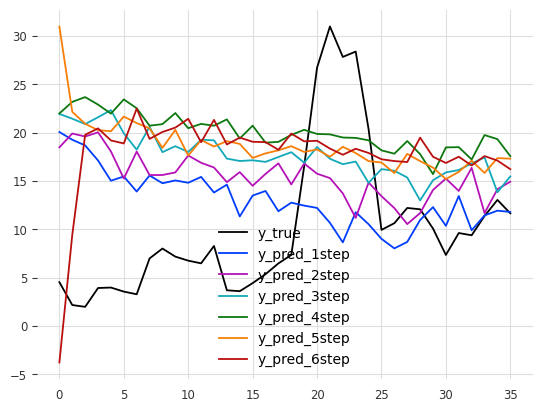

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 216   
4 | fc            | Sequential       | 78    
---------------------------------------------------
294       Trainable params
0         Non-trainable params
294       Total params
0.001     Total estimated model params size (MB)


⭐️⭐️⭐️⭐️⭐️⭐️⭐️
✨✨✨✨✨✨✨✨Quảng Ninh✨✨✨✨✨✨✨✨✨✨
🍋🍋🍋🍋🍋Check var feature selection:  ['Max_Daily_Rainfall', 'n_raining_days', 'n_hours_sunshine']
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  198
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 189.17it/s, train_loss=0.0418]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 177.10it/s, train_loss=0.0418]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.10it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 216   
4 | fc            | Sequential       | 78    
---------------------------------------------------
294       Trainable params
0         Non-trainable params
294       Total params
0.001     Total estimated model params size (MB)



🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  199
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 192.20it/s, train_loss=0.0121]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 182.59it/s, train_loss=0.0121]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 159.21it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 216   
4 | fc            | Sequential       | 78    
---------------------------------------------------
294       Trainable params
0         Non-trainable params
294       Total params
0.001     Total estimated model params size (MB)



🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  200
Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 129.48it/s, train_loss=0.0171] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 126.50it/s, train_loss=0.0171]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.97it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭
y_train_back:  198
x_train_back:  201


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 216   
4 | fc            | Sequential       | 78    
---------------------------------------------------
294       Trainable params
0         Non-trainable params
294       Total params
0.001     Total estimated model params size (MB)


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 211.92it/s, train_loss=0.00702]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 6/6 [00:00<00:00, 201.25it/s, train_loss=0.00702]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 239.58it/s]
🍭🍭🍭🍭🍭🍭🍭🍭🍭


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 216   
4 | fc            | Sequential       | 78    
---------------------------------------------------
294       Trainable params
0         Non-trainable params
294       Total params
0.001     Total estimated model params size (MB)


y_train_back:  198
x_train_back:  202
Epoch 1:  17%|█▋        | 1/6 [00:00<00:00, 93.67it/s, train_loss=0.0135]  

In [34]:
model_name_list = [
     "BlockRNNModel",
     "NBEATSModel",
     "NHiTSModel",
     "TFTModel",
    # "TCNModel", #still bug
]

for model_name in model_name_list:   
    print(f"✨✨✨✨✨✨✨✨{model_name}✨✨✨✨✨✨✨✨✨✨")
    for city in cities:
        print(f"✨✨✨✨✨✨✨✨{city}✨✨✨✨✨✨✨✨✨✨")
        df_train = pd.read_csv(output_process+city+'_train_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
        df_eval = pd.read_csv(output_process+city+'_test_preprocessed.csv', parse_dates=True, index_col= None, encoding = 'unicode_escape')
        scaler = joblib.load(output_process+city+'_train_scalerMinMaxNorm.save') #ok
        nstep = args.n_predicted_period_months
        selected_features = getDataWithSelectedFeature(city, nstep)

        lags_by_nstep = args.look_back + nstep - 1
        lags_past_covariates_by_nstep = [-lags_by_nstep+2,-lags_by_nstep+1,-lags_by_nstep] #Mảng này chứa ba giá trị tương ứng cho args.lookback 3

        pl_trainer_kwargs = {
                    "accelerator": "cpu",
                    # "devices": -1,
                    # "auto_select_gpus": True,
                }

        df_hyper_params = getHyperParams(model_name, city)

        if model_name == "BlockRNNModel":
            #suggest hyperparams
            hidden_dim = df_hyper_params['hidden_dim'].values[0]
            n_rnn_layers = df_hyper_params['n_rnn_layers'].values[0]
            dropout = df_hyper_params['dropout'].values[0]
            n_epochs = df_hyper_params['n_epochs'].values[0]
            random_state = df_hyper_params['random_state'].values[0]

            model = BlockRNNModel(
                                input_chunk_length = args.look_back,
                                output_chunk_length = args.n_predicted_period_months,
                                hidden_dim = hidden_dim,
                                n_rnn_layers = n_rnn_layers,
                                dropout = dropout,
                                n_epochs = 2,
                                pl_trainer_kwargs = pl_trainer_kwargs,
                                random_state=random_state)
        elif model_name == 'TFTModel':
            # Define the hyperparameters to optimize
            dropout = df_hyper_params['dropout'].values[0]
            n_epochs = df_hyper_params['n_epochs'].values[0]
            random_state = df_hyper_params['random_state'].values[0]
            # Create the TFTModel model
            model = TFTModel(
                            input_chunk_length = args.look_back,
                            output_chunk_length = args.n_predicted_period_months,
                            add_relative_index = True,
                            dropout = dropout,
                            n_epochs = 2,
                            pl_trainer_kwargs = pl_trainer_kwargs,
                            random_state=random_state)
        elif model_name == 'NHiTSModel':
            #suggest hyperparams
            MaxPool1d = bool(df_hyper_params['MaxPool1d'].values[0])
            dropout = df_hyper_params['dropout'].values[0]
            n_epochs = df_hyper_params['n_epochs'].values[0]
            random_state = df_hyper_params['random_state'].values[0]
            model = NHiTSModel(
                                input_chunk_length = args.look_back,
                                output_chunk_length = args.n_predicted_period_months,
                                MaxPool1d = MaxPool1d,
                                dropout = dropout,
                                n_epochs = 2 ,
                                pl_trainer_kwargs = pl_trainer_kwargs,
                                random_state=random_state)
        elif model_name == "NBEATSModel":
            dropout = df_hyper_params['dropout'].values[0]
            n_epochs = df_hyper_params['n_epochs'].values[0]
            random_state = df_hyper_params['random_state'].values[0]
            model = NBEATSModel(
                                    input_chunk_length = args.look_back,
                                    output_chunk_length = args.n_predicted_period_months,
                                    dropout = dropout,
                                    n_epochs = 2 ,
                                    pl_trainer_kwargs = pl_trainer_kwargs,
                                    random_state=random_state)
        elif model_name == "TCNModel":
            params = {
                'kernel_size': df_hyper_params["kernel_size"].values[0],
                'num_filters': df_hyper_params["num_filters"].values[0],
                'weight_norm': df_hyper_params["weight_norm"].values[0],
                'dilation_base': df_hyper_params["dilation_base"].values[0],
                'dropout': df_hyper_params["dropout"].values[0],
                'learning_rate': df_hyper_params["learning_rate"].values[0],
                'include_year': df_hyper_params["year"].values[0],
                'n_epochs': df_hyper_params["n_epochs"].values[0],
            }
            # select input and output chunk lengths
            params['input_chunk_length'] = args.look_back
            params['output_chunk_length'] = args.n_predicted_period_months  
            # optionally also add the (scaled) year value as a past covariate
            if params['include_year']:
                encoders = {"datetime_attribute": {"past": ["year"]},
                            "transformer": Scaler()}
            else:
                encoders = None
            params['encoders'] = encoders
            param = params
            model = TCNModel(
                input_chunk_length=param['input_chunk_length'],
                output_chunk_length=param['output_chunk_length'],
                batch_size=16,
                n_epochs=param['n_epochs'],
                nr_epochs_val_period=1,
                kernel_size=param['kernel_size'],
                num_filters=param['num_filters'],
                weight_norm=param['weight_norm'],
                dilation_base=param['dilation_base'],
                dropout=param['dropout'],
                optimizer_kwargs={"lr": param['learning_rate']},
                add_encoders=param['encoders'],
                likelihood=GaussianLikelihood(),
                pl_trainer_kwargs=pl_trainer_kwargs,
                model_name="tcn_model",
                force_reset=True,
                save_checkpoints=True,
            )
              
        df, model = output_prediction_for_location(df_train, df_eval, model, location=city, feature_list=selected_features,
                                                            labels=args.labels, scaler=scaler)
        
        folder_save_rs_path = f"./predict_results/{model_name}/"
        folder_save_model_path = f"./trained_models/{model_name}/"
        if not (os.path.isdir(folder_save_rs_path)):
            os.makedirs(folder_save_rs_path, exist_ok=True)
        if not (os.path.isdir(folder_save_model_path)):
            os.makedirs(folder_save_model_path, exist_ok=True)
        df.to_excel(f"{folder_save_rs_path}0_train_{nstep}nstep_denguefever_prediction_results_by_{model_name}_in_{city}.xlsx")
        pickle.dump(model, open(f"{folder_save_model_path}{nstep}nstep_denguefever_{model_name}_in_{city}.sav", 'wb'))